## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [8]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.1,0.5,0.9]
redice_lr_patient = [5,10,20]

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.10, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

Epoch 11/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.7125 - acc: 0.4025 - val_loss: 1.7769 - val_acc: 0.3799
Epoch 12/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.6933 - acc: 0.4095 - val_loss: 1.7623 - val_acc: 0.3859
Epoch 13/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.6743 - acc: 0.4177 - val_loss: 1.7480 - val_acc: 0.3877
Epoch 14/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.6574 - acc: 0.4223 - val_loss: 1.7365 - val_acc: 0.3909
Epoch 15/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.6425 - acc: 0.4265 - val_loss: 1.7271 - val_acc: 0.3950
Epoch 16/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.6281 - acc: 0.4309 - val_loss: 1.7152 - val_acc: 0.3964
Epoch 17/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.6149 - acc: 0.4347 - val_loss: 1.7057 - val_acc: 0.4012
Epoch 18/25
50000/50000 [==

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 151us/step - loss: 2.6292 - acc: 0.1643 - val_loss: 2.4987 - val_acc: 0.2334
Epoch 2/25
50000/50000 [==============================] - 6s 125us/step - loss: 2.2089 - acc: 0.2598 - val_loss: 2.1991 - val_acc: 0.2731
Epoch 3/25
50000/50000 [==============================] - 6s 126us/step - loss: 2.0445 - acc: 0.2993 - val_loss: 2.0565 - val_acc: 0.2933
Epoch 4/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.9530 - acc: 0.3247 - val_loss: 1.9796 - val_acc: 0.3180
Epoch 5/25
50000/50000 [==============================] - 6s 128us/step - loss: 1.8919 - acc: 0.3441 - val_loss: 1.9226 - val_acc: 0.3330
Epoch 6/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.8446 - acc: 0.3608 - val_loss: 1.8821 - val_acc: 0.3511
Epoch 7/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.8071 - acc: 0.3717 - val_loss: 1.8502 - 

Epoch 24/25
50000/50000 [==============================] - 7s 130us/step - loss: 1.5437 - acc: 0.4618 - val_loss: 1.6661 - val_acc: 0.4226
Epoch 25/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.5354 - acc: 0.4642 - val_loss: 1.6591 - val_acc: 0.4234
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
bat

50000/50000 [==============================] - 6s 124us/step - loss: 1.7185 - acc: 0.4012 - val_loss: 1.7973 - val_acc: 0.3777
Epoch 12/25
50000/50000 [==============================] - 6s 124us/step - loss: 1.6982 - acc: 0.4079 - val_loss: 1.7813 - val_acc: 0.3832
Epoch 13/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.6793 - acc: 0.4136 - val_loss: 1.7679 - val_acc: 0.3868
Epoch 14/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.6630 - acc: 0.4198 - val_loss: 1.7539 - val_acc: 0.3909
Epoch 15/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.6475 - acc: 0.4254 - val_loss: 1.7433 - val_acc: 0.3953
Epoch 16/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.6324 - acc: 0.4316 - val_loss: 1.7334 - val_acc: 0.3975
Epoch 17/25
50000/50000 [==============================] - 7s 130us/step - loss: 1.6179 - acc: 0.4360 - val_loss: 1.7212 - val_acc: 0.4024
Epoch 18/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 167us/step - loss: 2.6751 - acc: 0.1586 - val_loss: 2.5523 - val_acc: 0.1976
Epoch 2/25
50000/50000 [==============================] - 7s 132us/step - loss: 2.2285 - acc: 0.2620 - val_loss: 2.2118 - val_acc: 0.2714
Epoch 3/25
50000/50000 [==============================] - 7s 132us/step - loss: 2.0554 - acc: 0.3044 - val_loss: 2.0747 - val_acc: 0.3000
Epoch 4/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.9640 - acc: 0.3299 - val_loss: 1.9916 - val_acc: 0.3270
Epoch 5/25
50000/50000 [==============================] - 7s 134us/step - loss: 1.9018 - acc: 0.3467 - val_loss: 1.9389 - val_acc: 0.3409
Epoch 6/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.8539 - acc: 0.3624 - val_loss: 1.8998 - val_acc: 0.3537
Epoch 7/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.8152 - acc: 0.3732 - val_loss: 1.8698 - 

50000/50000 [==============================] - 7s 136us/step - loss: 0.6213 - acc: 0.8018 - val_loss: 1.3437 - val_acc: 0.5512
Epoch 24/25
50000/50000 [==============================] - 7s 134us/step - loss: 0.6162 - acc: 0.8044 - val_loss: 1.3440 - val_acc: 0.5509
Epoch 25/25
50000/50000 [==============================] - 7s 134us/step - loss: 0.6141 - acc: 0.8055 - val_loss: 1.3469 - val_acc: 0.5517
Numbers of exp: 10, reduce_factor: 0.10, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_

50000/50000 [==============================] - 7s 136us/step - loss: 1.4534 - acc: 0.4967 - val_loss: 1.5907 - val_acc: 0.4366
Epoch 11/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.4349 - acc: 0.5030 - val_loss: 1.5868 - val_acc: 0.4400
Epoch 12/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.4191 - acc: 0.5105 - val_loss: 1.5805 - val_acc: 0.4391
Epoch 13/25
50000/50000 [==============================] - 6s 128us/step - loss: 1.4035 - acc: 0.5149 - val_loss: 1.5702 - val_acc: 0.4478
Epoch 14/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.3901 - acc: 0.5195 - val_loss: 1.5642 - val_acc: 0.4453
Epoch 15/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.3764 - acc: 0.5256 - val_loss: 1.5552 - val_acc: 0.4543
Epoch 16/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.3635 - acc: 0.5315 - val_loss: 1.5510 - val_acc: 0.4521
Epoch 17/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 178us/step - loss: 2.1892 - acc: 0.2792 - val_loss: 2.0532 - val_acc: 0.3250
Epoch 2/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.7796 - acc: 0.3853 - val_loss: 1.8572 - val_acc: 0.3718
Epoch 3/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.6768 - acc: 0.4156 - val_loss: 1.7552 - val_acc: 0.4005
Epoch 4/25
50000/50000 [==============================] - 6s 128us/step - loss: 1.6156 - acc: 0.4379 - val_loss: 1.6990 - val_acc: 0.4131
Epoch 5/25
50000/50000 [==============================] - 6s 128us/step - loss: 1.5713 - acc: 0.4520 - val_loss: 1.6719 - val_acc: 0.4207
Epoch 6/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.5341 - acc: 0.4669 - val_loss: 1.6632 - val_acc: 0.4228
Epoch 7/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.5055 - acc: 0.4748 - val_loss: 1.6334 - 

Epoch 24/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.2529 - acc: 0.5724 - val_loss: 1.5141 - val_acc: 0.4757
Epoch 25/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.2434 - acc: 0.5766 - val_loss: 1.5090 - val_acc: 0.4769
Numbers of exp: 15, reduce_factor: 0.90, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_46 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
bat

50000/50000 [==============================] - 7s 145us/step - loss: 1.4100 - acc: 0.5127 - val_loss: 1.5744 - val_acc: 0.4486
Epoch 12/25
50000/50000 [==============================] - 7s 145us/step - loss: 1.3918 - acc: 0.5181 - val_loss: 1.5648 - val_acc: 0.4544
Epoch 13/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.3769 - acc: 0.5246 - val_loss: 1.5543 - val_acc: 0.4612
Epoch 14/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.3623 - acc: 0.5308 - val_loss: 1.5570 - val_acc: 0.4568
Epoch 15/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.3479 - acc: 0.5348 - val_loss: 1.5426 - val_acc: 0.4629
Epoch 16/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.3345 - acc: 0.5406 - val_loss: 1.5378 - val_acc: 0.4585
Epoch 17/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.3227 - acc: 0.5443 - val_loss: 1.5308 - val_acc: 0.4670
Epoch 18/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 10s 202us/step - loss: 1.8117 - acc: 0.3771 - val_loss: 2.1715 - val_acc: 0.2852
Epoch 2/25
50000/50000 [==============================] - 7s 141us/step - loss: 1.5321 - acc: 0.4587 - val_loss: 1.9996 - val_acc: 0.3044
Epoch 3/25
50000/50000 [==============================] - 7s 140us/step - loss: 1.4309 - acc: 0.4962 - val_loss: 2.2721 - val_acc: 0.2678
Epoch 4/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.3542 - acc: 0.5214 - val_loss: 1.9915 - val_acc: 0.3209
Epoch 5/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.2982 - acc: 0.5410 - val_loss: 1.8862 - val_acc: 0.3623
Epoch 6/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.2518 - acc: 0.5569 - val_loss: 2.2742 - val_acc: 0.3013
Epoch 7/25
50000/50000 [==============================] - 6s 128us/step - loss: 1.1979 - acc: 0.5791 - val_loss: 2.2218 -

50000/50000 [==============================] - 7s 135us/step - loss: 1.4267 - acc: 0.5053 - val_loss: 1.5820 - val_acc: 0.4483
Epoch 23/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.4150 - acc: 0.5092 - val_loss: 1.5751 - val_acc: 0.4511
Epoch 24/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.4020 - acc: 0.5137 - val_loss: 1.5752 - val_acc: 0.4514
Epoch 25/25
50000/50000 [==============================] - 7s 130us/step - loss: 1.3915 - acc: 0.5171 - val_loss: 1.5681 - val_acc: 0.4515
Numbers of exp: 20, reduce_factor: 0.10, reduce_patient: 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________


50000/50000 [==============================] - 7s 136us/step - loss: 1.6779 - acc: 0.4155 - val_loss: 1.7766 - val_acc: 0.3922
Epoch 10/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.6483 - acc: 0.4272 - val_loss: 1.7471 - val_acc: 0.3995
Epoch 11/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.6220 - acc: 0.4353 - val_loss: 1.7313 - val_acc: 0.4024
Epoch 12/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.5974 - acc: 0.4429 - val_loss: 1.7147 - val_acc: 0.4058
Epoch 13/25
50000/50000 [==============================] - 7s 130us/step - loss: 1.5771 - acc: 0.4496 - val_loss: 1.6951 - val_acc: 0.4142
Epoch 14/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.5572 - acc: 0.4575 - val_loss: 1.6856 - val_acc: 0.4146
Epoch 15/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.5384 - acc: 0.4659 - val_loss: 1.6725 - val_acc: 0.4197
Epoch 16/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 10s 200us/step - loss: 2.5218 - acc: 0.1897 - val_loss: 2.3731 - val_acc: 0.2394
Epoch 2/25
50000/50000 [==============================] - 6s 129us/step - loss: 2.1677 - acc: 0.2751 - val_loss: 2.1623 - val_acc: 0.2835
Epoch 3/25
50000/50000 [==============================] - 6s 130us/step - loss: 2.0103 - acc: 0.3171 - val_loss: 2.0492 - val_acc: 0.3083
Epoch 4/25
50000/50000 [==============================] - 7s 130us/step - loss: 1.9122 - acc: 0.3446 - val_loss: 1.9671 - val_acc: 0.3300
Epoch 5/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.8432 - acc: 0.3655 - val_loss: 1.8964 - val_acc: 0.3464
Epoch 6/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.7878 - acc: 0.3826 - val_loss: 1.8405 - val_acc: 0.3640
Epoch 7/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.7438 - acc: 0.3973 - val_loss: 1.8045 -

Epoch 24/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.4074 - acc: 0.5147 - val_loss: 1.5957 - val_acc: 0.4415
Epoch 25/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.3971 - acc: 0.5170 - val_loss: 1.5906 - val_acc: 0.4428
Numbers of exp: 25, reduce_factor: 0.90, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_76 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
ba

50000/50000 [==============================] - 7s 134us/step - loss: 1.6111 - acc: 0.4417 - val_loss: 1.7146 - val_acc: 0.4106
Epoch 12/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.5879 - acc: 0.4498 - val_loss: 1.6951 - val_acc: 0.4166
Epoch 13/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.5668 - acc: 0.4578 - val_loss: 1.6790 - val_acc: 0.4211
Epoch 14/25
50000/50000 [==============================] - 7s 140us/step - loss: 1.5470 - acc: 0.4647 - val_loss: 1.6705 - val_acc: 0.4221
Epoch 15/25
50000/50000 [==============================] - 7s 140us/step - loss: 1.5292 - acc: 0.4705 - val_loss: 1.6571 - val_acc: 0.4236
Epoch 16/25
50000/50000 [==============================] - 7s 143us/step - loss: 1.5122 - acc: 0.4758 - val_loss: 1.6479 - val_acc: 0.4279
Epoch 17/25
50000/50000 [==============================] - 7s 144us/step - loss: 1.4955 - acc: 0.4833 - val_loss: 1.6423 - val_acc: 0.4301
Epoch 18/25
50000/50000 [==============

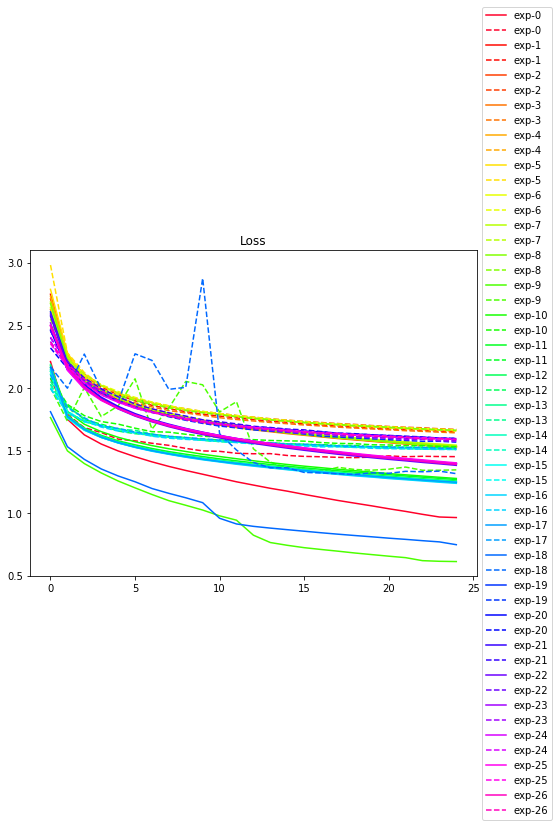

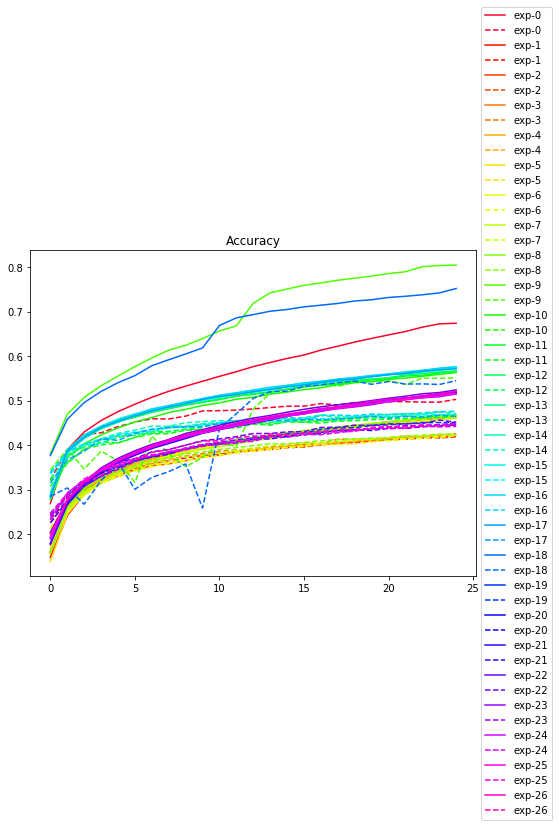

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()